In [42]:
import os
import sys
sys.path.append('..')

import pandas as pd
from simpledbf import Dbf5
from simpledbf.simpledbf import DbfBase
from pyopensus import Opensus
from pyopensus.dbf_fix import DBFIX


ImportError: cannot import name 'DBF_v2' from 'pyopensus.dbf_fix' (c:\Users\Higor Monteiro\Documents\code\pyopensus\notebooks\..\pyopensus\dbf_fix.py)

In [6]:

basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
sihpath = os.path.join(basepath, "opendatasus", "sihsus")
siapath = os.path.join(basepath, "opendatasus", "siasus")
simpath = os.path.join(basepath, "opendatasus", "sim")
sinascpath = os.path.join(basepath, "opendatasus", "sinasc")
cnespath = os.path.join(basepath, "opendatasus", "cnes")


In [10]:
opensus = Opensus()

In [11]:
opensus.listdir('SIASUS')

03-12-19  12:03PM                 2971 ABDF1112.dbc
03-12-19  12:03PM                 3183 ABMG1112.dbc
09-12-16  08:45AM                 3143 ABOAC1502.dbc
09-12-16  08:45AM                 2996 ABOAC1503.dbc
09-12-16  08:45AM                 3044 ABOAC1504.dbc
09-12-16  08:45AM                 2929 ABOAC1505.dbc
09-12-16  08:45AM                 3050 ABOAC1507.dbc
10-07-16  08:37AM                 3072 ABOAC1508.dbc
11-07-16  02:31PM                 2968 ABOAC1509.dbc
11-07-16  02:31PM                 3057 ABOAC1511.dbc
05-08-17  01:05PM                 2929 ABOAC1602.dbc
06-05-17  10:18AM                 3081 ABOAC1604.dbc
10-09-17  10:23AM                 3098 ABOAC1608.dbc
11-06-17  11:06AM                 2969 ABOAC1609.dbc
02-05-18  08:34AM                 3075 ABOAC1612.dbc
07-06-18  03:28AM                 2973 ABOAC1706.dbc
09-04-20  05:56PM                 3019 ABOAC1906.dbc
10-08-20  03:54PM                 3150 ABOAC1907.dbc
10-08-20  03:54PM                 3230 ABOAC1908

In [ ]:
# teste -- SIM --

In [12]:
opensus.retrieve_year(simpath, 'SIM', 'CE', 2000, 'DO', to_dbf=True, verbose=True)

...
Download do arquivo DOCE2000.dbc ... Feito.


In [16]:
do2000_dbf = Dbf5(os.path.join(simpath, "DBF", "DOCE2000.dbf"))
print(do2000_dbf.numrec, do2000_dbf.numfields)

33641 40


In [17]:
do2000_df = do2000_dbf.to_dataframe()
do2000_df.head()

,contador,TIPOBITO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,...,NECROPSIA,CAUSABAS,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,CIRCOBITO,ACIDTRAB,FONTE
0,1,2,29062000,815,22121967,432,1,4,1,3,...,NaN,R98,*R98X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,23022000,823,18061963,436,1,1,9,9,...,2,X954,*T692,*T019,*X954,NaN,NaN,3,NaN,9
2,3,2,18092000,823,10051957,443,1,1,1,4,...,2,X959,*R092,*S129,NaN,*X959,NaN,3,NaN,3
3,4,2,09102000,831,13051956,444,1,1,2,3,...,2,Y249,*R092,*S279,*Y249,NaN,NaN,9,2,1
4,5,2,01012000,821,02021976,423,1,4,1,2,...,NaN,V892,*S069,*V892,NaN,NaN,NaN,1,2,3


In [18]:
# Teste -- SINASC --
opensus.retrieve_year(sinascpath, 'SINASC', 'CE', 2000, 'DN', to_dbf=True, verbose=True)

...
Download do arquivo DNCE2000.dbc ... Feito.


In [20]:
dn2000_dbf = Dbf5(os.path.join(sinascpath, "DBF", "DNCE2000.dbf"))
print(dn2000_dbf.numrec, dn2000_dbf.numfields)

143393 20


In [21]:
dn2000_df = dn2000_dbf.to_dataframe()
dn2000_df.head()

,contador,LOCNASC,CODMUNNASC,IDADEMAE,ESTCIVMAE,ESCMAE,QTDFILVIVO,QTDFILMORT,CODMUNRES,GESTACAO,GRAVIDEZ,PARTO,CONSULTAS,DTNASC,SEXO,APGAR1,APGAR5,RACACOR,PESO,CODANOMAL
0,1,1,1302603,25,2,5,NaN,NaN,2304400,5,1,1,NaN,12092000,1,08,10,1,3660,NaN
1,2,1,1501402,24,2,5,02,0,2301703,5,1,1,4,25022000,2,09,10,4,3650,NaN
2,3,1,1500602,16,5,2,01,00,2309607,5,1,2,9,14112000,2,09,10,4,3300,Q661
3,4,1,1600055,23,1,4,NaN,NaN,2310506,5,1,1,3,06042000,2,08,09,4,2770,NaN
4,5,1,1600303,16,5,2,00,00,2310506,5,1,1,2,26052000,2,07,09,4,3600,NaN


In [27]:
# Teste -- SIHSUS --
opensus.retrieve_year(sihpath, 'SIHSUS', 'CE', 2009, 'RD', to_dbf=True, verbose=True)

Download do arquivo RDCE0901.dbc ... Feito.
Download do arquivo RDCE0902.dbc ... Feito.
Download do arquivo RDCE0903.dbc ... Feito.
Download do arquivo RDCE0904.dbc ... Feito.
Download do arquivo RDCE0905.dbc ... Feito.
Download do arquivo RDCE0906.dbc ... Feito.
Download do arquivo RDCE0907.dbc ... Feito.
Download do arquivo RDCE0908.dbc ... Feito.
Download do arquivo RDCE0909.dbc ... Feito.
Download do arquivo RDCE0910.dbc ... Feito.
Download do arquivo RDCE0911.dbc ... Feito.
Download do arquivo RDCE0912.dbc ... Feito.


In [37]:
months = [ f'{n:2.0f}'.replace(' ', "0") for n in range(1,13) ]

numrec, numfields = [], []
for year in ['09']:
    for month in months:
        aih_dbf = Dbf5(os.path.join(sihpath, "DBF", f"RDCE{year}{month}.dbf"))
        numrec.append(aih_dbf.numrec)
        numfields.append(aih_dbf.numfields)

In [38]:
sum(numrec)

503675

In [39]:
numfields

[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]

In [40]:
ex = aih_dbf.to_dataframe()

In [41]:
ex

,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,CID_ASSO,CID_MORTE,COMPLEX,FINANC,FAEC_TP,REGCT,RACA_COR,ETNIA,SEQUENCIA,REMESSA
0,230000,2009,12,02,07059280001981,2309105162320,1,62430000,230470,19720420,...,NaN,NaN,02,06,NaN,0000,03,NaN,138,HE23000001N200912.DTS
1,230000,2009,12,02,07059280001981,2309105162331,1,62430000,230470,19811005,...,NaN,NaN,02,06,NaN,0000,03,NaN,139,HE23000001N200912.DTS
2,230000,2009,12,02,07059280001981,2309105162342,1,62430000,230470,19770605,...,NaN,NaN,02,06,NaN,0000,03,NaN,140,HE23000001N200912.DTS
3,230000,2009,12,02,07059280001981,2309105162353,1,62430000,230470,19900313,...,NaN,NaN,02,06,NaN,0000,03,NaN,141,HE23000001N200912.DTS
4,230000,2009,12,03,NaN,2309105426914,1,63320000,230180,19600902,...,NaN,NaN,02,06,NaN,0000,03,NaN,253,HE23000001N200912.DTS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39741,231410,2009,12,01,NaN,2309105619139,1,62300000,231410,19840613,...,NaN,NaN,02,06,NaN,0000,99,NaN,31,HM23141001N200912.DTS
39742,231410,2009,12,02,NaN,2309105616928,1,62300000,231410,19681003,...,NaN,NaN,02,06,NaN,0000,99,NaN,32,HM23141001N200912.DTS
39743,231410,2009,12,03,NaN,2309105619073,1,62300000,231410,19670829,...,NaN,NaN,02,06,NaN,0000,99,NaN,183,HM23141001N200912.DTS
39744,231410,2009,12,03,NaN,2309105619095,1,62300000,231410,19620330,...,NaN,NaN,02,06,NaN,0000,99,NaN,184,HM23141001N200912.DTS


In [42]:
ex["N_AIH"].value_counts()

N_AIH
2309104625608    2
2309104625619    2
2309104625487    2
2309104625498    2
2309104290900    2
                ..
2309104528820    1
2309104528830    1
2309104528841    1
2309104528852    1
2309105619106    1
Name: count, Length: 39739, dtype: int64

In [43]:
ex[ex["N_AIH"]=="2309104625608"]

,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,CID_ASSO,CID_MORTE,COMPLEX,FINANC,FAEC_TP,REGCT,RACA_COR,ETNIA,SEQUENCIA,REMESSA
21372,230440,2009,12,05,07954571003715,2309104625608,1,60711560,230440,19740324,...,NaN,NaN,02,06,NaN,0000,99,NaN,13193,HM23044001N200912.DTS
21373,230440,2009,12,05,07954571003715,2309104625608,5,60711560,230440,19740324,...,NaN,NaN,02,06,NaN,0000,99,NaN,13194,HM23044001N200912.DTS


In [44]:
ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39746 entries, 0 to 39745
Data columns (total 86 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   UF_ZI       39746 non-null  object 
 1   ANO_CMPT    39746 non-null  object 
 2   MES_CMPT    39746 non-null  object 
 3   ESPEC       39746 non-null  object 
 4   CGC_HOSP    28202 non-null  object 
 5   N_AIH       39746 non-null  object 
 6   IDENT       39746 non-null  object 
 7   CEP         39746 non-null  object 
 8   MUNIC_RES   39746 non-null  object 
 9   NASC        39746 non-null  object 
 10  SEXO        39746 non-null  object 
 11  UTI_MES_IN  39746 non-null  int64  
 12  UTI_MES_AN  39746 non-null  int64  
 13  UTI_MES_AL  39746 non-null  int64  
 14  UTI_MES_TO  39746 non-null  int64  
 15  MARCA_UTI   39746 non-null  object 
 16  UTI_INT_IN  39746 non-null  int64  
 17  UTI_INT_AN  39746 non-null  int64  
 18  UTI_INT_AL  39746 non-null  int64  
 19  UTI_INT_TO  39746 non-nul

In [46]:
ex["MARCA_UTI"].value_counts()

MARCA_UTI
00    38525
75      888
81      173
74       84
78       71
83        4
99        1
Name: count, dtype: int64

In [47]:
ex.columns

Index(['UF_ZI', 'ANO_CMPT', 'MES_CMPT', 'ESPEC', 'CGC_HOSP', 'N_AIH', 'IDENT',
       'CEP', 'MUNIC_RES', 'NASC', 'SEXO', 'UTI_MES_IN', 'UTI_MES_AN',
       'UTI_MES_AL', 'UTI_MES_TO', 'MARCA_UTI', 'UTI_INT_IN', 'UTI_INT_AN',
       'UTI_INT_AL', 'UTI_INT_TO', 'DIAR_ACOM', 'QT_DIARIAS', 'PROC_SOLIC',
       'PROC_REA', 'VAL_SH', 'VAL_SP', 'VAL_SADT', 'VAL_RN', 'VAL_ACOMP',
       'VAL_ORTP', 'VAL_SANGUE', 'VAL_SADTSR', 'VAL_TRANSP', 'VAL_OBSANG',
       'VAL_PED1AC', 'VAL_TOT', 'VAL_UTI', 'US_TOT', 'DT_INTER', 'DT_SAIDA',
       'DIAG_PRINC', 'DIAG_SECUN', 'COBRANCA', 'NATUREZA', 'GESTAO', 'RUBRICA',
       'IND_VDRL', 'MUNIC_MOV', 'COD_IDADE', 'IDADE', 'DIAS_PERM', 'MORTE',
       'NACIONAL', 'NUM_PROC', 'CAR_INT', 'TOT_PT_SP', 'CPF_AUT', 'HOMONIMO',
       'NUM_FILHOS', 'INSTRU', 'CID_NOTIF', 'CONTRACEP1', 'CONTRACEP2',
       'GESTRISCO', 'INSC_PN', 'SEQ_AIH5', 'CBOR', 'CNAER', 'VINCPREV',
       'GESTOR_COD', 'GESTOR_TP', 'GESTOR_CPF', 'GESTOR_DT', 'CNES',
       'CNPJ_MANT', 'INFE

In [60]:
ex["DT_SAIDA"].notnull().sum()

39746

In [51]:
ex["CID_ASSO"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
39741    NaN
39742    NaN
39743    NaN
39744    NaN
39745    NaN
Name: CID_ASSO, Length: 39746, dtype: object

In [58]:
ex["DIAG_PRINC"].value_counts()[:20]

DIAG_PRINC
O800    4239
A09      720
J189     655
A049     654
O034     641
J158     641
F29      634
O809     471
J459     453
O808     438
I500     420
O821     419
J46      386
J188     386
Z470     383
O820     355
O420     355
N390     351
I64      343
Z302     324
Name: count, dtype: int64

In [59]:
ex.shape

(39746, 86)

In [62]:
ex["DT_INTER"]

0        20091211
1        20091211
2        20091110
3        20091110
4        20091105
           ...   
39741    20091223
39742    20091220
39743    20091222
39744    20091110
39745    20091111
Name: DT_INTER, Length: 39746, dtype: object

In [65]:
ex["DT_INTER_1"] = pd.to_datetime(ex["DT_INTER"], format="%Y%m%d", errors='coerce')
ex["DT_SAIDA_1"] = pd.to_datetime(ex["DT_SAIDA"], format="%Y%m%d", errors='coerce')

<Axes: >

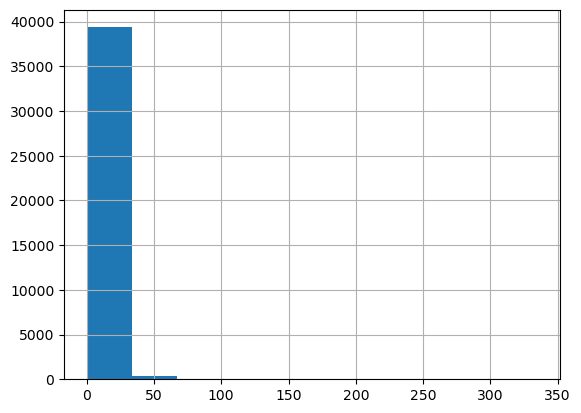

In [69]:
ex["DIAS_PERM"].hist()

In [73]:
ex1 = ex[ex["DIAS_PERM"]>20][["DIAG_PRINC", "DIAG_SECUN", "IDADE", "DIAS_PERM"]]

In [78]:
ex1.groupby("DIAG_PRINC").sum()[:20]

,DIAG_SECUN,IDADE,DIAS_PERM
DIAG_PRINC,,,
A049,0,38,67
A059,0,55,65
A085,0,79,33
A150,0,167,119
A153,0,75,51
A310,0,136,62
A319,I64,268,216
A321,0,3,25
A391,0,57,23


In [80]:
ex1.set_index("DIAG_PRINC")

,DIAG_SECUN,IDADE,DIAS_PERM
DIAG_PRINC,,,
I10,NaN,44,32
J168,NaN,57,22
E86,NaN,5,34
L97,NaN,64,37
A059,NaN,55,65
...,...,...,...
A085,NaN,79,33
J189,NaN,32,22
P072,NaN,3,26


In [2]:
import rpy2

In [14]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

#import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

In [4]:
read_dbc = importr('read.dbc')

In [7]:
ex = read_dbc.read_dbc(os.path.join(cnespath, "DBC", "STCE2308.dbc"))

In [35]:
read_dbc.dbc2dbf(os.path.join(cnespath, "DBC", "STCE2308.dbc"), os.path.join(cnespath, "STCE2308.DBF"))

1


In [40]:
ex_dbf = Dbf5(os.path.join(cnespath, "STCE2308.DBF"), codec='latin')

In [41]:
ex_dbf.to_dataframe()

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,NIV_DEP,CNPJ_MAN,COD_IR,REGSAUDE,MICR_REG,...,AP07CV02,AP07CV03,AP07CV04,AP07CV05,AP07CV06,AP07CV07,ATEND_PR,DT_ATUAL,COMPETEN,NAT_JUR
0,0439924,230010,63240000,00000000000000,3,3,07411531000116,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202304,202308,1244
1,2497662,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202207,202308,1244
2,2497670,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202304,202308,1244
3,2497689,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202307,202308,1244
4,2726319,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202309,202308,1244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14214,7585675,231410,62300000,00000000000000,3,3,10462497000113,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202208,202308,1244
14215,7946376,231410,62300000,00000000000000,3,3,10462497000113,NaN,13,13,...,0,0,0,0,0,0,1,202304,202308,1244
14216,9403426,231410,62300000,00000000000000,3,3,10462497000113,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202208,202308,1244
14217,9430970,231410,62300000,00000000000000,3,3,10462497000113,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202111,202308,1244


In [13]:
pd.DataFrame(ex)

,0,1,2,3,4,5,6,7,8,9,...,14209,14210,14211,14212,14213,14214,14215,14216,14217,14218
0,419,2209,2210,2211,3244,8917,9299,11101,11291,13202,...,10357,10520,10559,10948,10957,11313,12069,13041,13124,13704
1,1,1,1,1,1,1,1,1,1,1,...,184,184,184,184,184,184,184,184,184,184
2,2194,2194,2194,2194,2194,2194,2194,2194,2194,2194,...,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695
3,1,1,1,1,1,1,1,1,1,7827,...,1,1,1,1,1,1,1,1,1,8096
4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
204,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
205,57,48,57,60,62,57,47,57,57,48,...,57,59,49,57,57,49,57,49,40,24
206,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [22]:
with (robjects.default_converter + pandas2ri.converter).context():
    pd_from_r_df = robjects.conversion.get_conversion().rpy2py(ex)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaa in position 2: invalid start byte

In [23]:
pandas2ri.ri2py_dataframe(ex)

AttributeError: module 'rpy2.robjects.pandas2ri' has no attribute 'ri2py_dataframe'

In [25]:
ex

CNES,CODUFMUN,COD_CEP,...,DT_ATUAL,COMPETEN,NAT_JUR
0439924,230010,63240...,...,202304,202308,1244
2497662,230010,63240...,,202207,202308,1244
2497670,230010,63240...,,202304,202308,1244
2497689,230010,63240...,,202307,202308,1244
...,...,...,,...,...,...
7946376,231410,62300...,,202304,202308,1244
9403426,231410,62300...,,202208,202308,1244
9430970,231410,62300...,,202111,202308,1244
9698353,231410,62300...,,202007,202308,2062


In [28]:
ex.to_csvfile(os.path.join(cnespath, "STCE2308.csv"))

<rpy2.rinterface_lib.sexp.NULLType object at 0x000001EC5003A050> [0]

In [30]:
tt = pd.read_csv(os.path.join(cnespath, "STCE2308.csv"), encoding='latin')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_12536\1128369585.py:1: DtypeWarning: Columns (10,11,12,25) have mixed types. Specify dtype option on import or set low_memory=False.
  tt = pd.read_csv(os.path.join(cnespath, "STCE2308.csv"), encoding='latin')


In [31]:
tt

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,NIV_DEP,CNPJ_MAN,COD_IR,REGSAUDE,MICR_REG,...,AP07CV02,AP07CV03,AP07CV04,AP07CV05,AP07CV06,AP07CV07,ATEND_PR,DT_ATUAL,COMPETEN,NAT_JUR
1,439924,230010,63240000,0,3,3,7411531000116,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202304,202308,1244
2,2497662,230010,63240000,0,3,3,7411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202207,202308,1244
3,2497670,230010,63240000,0,3,3,7411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202304,202308,1244
4,2497689,230010,63240000,0,3,3,7411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202307,202308,1244
5,2726319,230010,63240000,0,3,3,7411531000116,NaN,0019,0019,...,0,0,0,0,0,0,1,202309,202308,1244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14215,7585675,231410,62300000,0,3,3,10462497000113,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202208,202308,1244
14216,7946376,231410,62300000,0,3,3,10462497000113,NaN,13,13,...,0,0,0,0,0,0,1,202304,202308,1244
14217,9403426,231410,62300000,0,3,3,10462497000113,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202208,202308,1244
14218,9430970,231410,62300000,0,3,3,10462497000113,NaN,NaN,NaN,...,0,0,0,0,0,0,1,202111,202308,1244
